In [1]:
# shift-scale-layer

# h(x) = f( [s * (x+c) * w] + b )

# x.shape = (1, m) where m is the number of features (dimension of input space):(vector)
# b.shape = (1) bias:(scalar)
# w.shape = (m, n) where m is the number of features and n is the number of units (dimension of output space) :(matrix)

# new params
# s.shape = (1) scale parameter - user specified > 0 (or >= 1) number or drawn from distribution:(scalar)
# c.shape = (1, m) feature shift vector - user specied real number of drawn from distribution:(vector)

# noraml dense layer

# h(x) = f( [x*w] + b )

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

import numpy as np

import lal
import lalsimulation as lalsim

# from scrinet.interfaces import lalutils, rotations 
from wispy import lalutils, rotations 


from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev5
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split

1.1785016498623269 1.2246467991473532e-16 -0.0


/Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


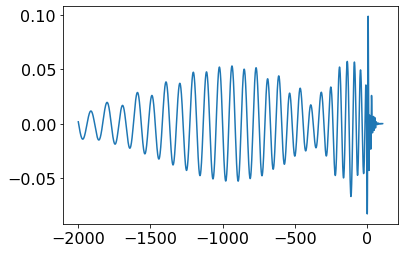

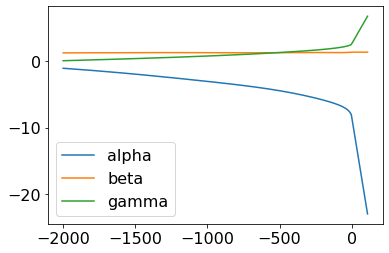

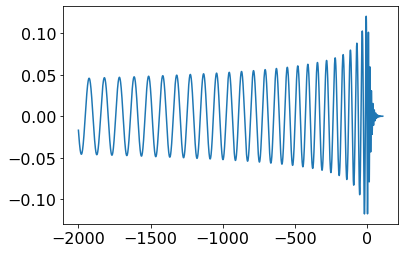

In [307]:
params = lalutils.gen_td_modes_wf_params(
    m1=100,
    m2=10,
    approximant=lalsim.SEOBNRv4P,
    S1x=0.99,
    S1y=0.,
    S2x=0.99,
    S2y=0.,
    f_min=12,
    f_ref=12,
    phiRef=1.2)

# t_min=-5000
# t_min=-1000
t_min=-2000
times, hlms = lalutils.gen_td_modes_wf(params, eob_all_ell_2_modes=True, modes=[[2,2],[2,1]], t_min=t_min, t_max=110)


thetaJN, alpha0, phi_aligned = rotations.compute_L_to_J_angles(
    mass1=params['m1'], mass2=params['m2'], f_ref=params['f_min'], inc=0, phiref=params['phiRef'],
    spin1x=params['S1x'], spin1y=params['S1y'], spin1z=params['S1z'],
    spin2x=params['S2x'], spin2y=params['S2y'], spin2z=params['S2z'])
print(thetaJN, alpha0, phi_aligned)

wr = rotations.WaveformRotations(
    times=times,
    hlms=hlms, 
    frame='inertial-L',
    alpha0=alpha0,
    thetaJN=thetaJN,
    phi0=phi_aligned) 


plt.figure()
plt.plot(wr.times, wr.hlms[(2,2)], label='alpha')

wr.from_inertial_frame_to_coprecessing_frame()

plt.figure()
plt.plot(wr.times, wr.alpha, label='alpha')
plt.plot(wr.times, wr.beta, label='beta')
plt.plot(wr.times, wr.gamma, label='gamma')
plt.legend()

# wr.from_coprecessing_frame_to_inertial_frame()

plt.figure()
plt.plot(wr.times, wr.hlms[(2,2)], label='alpha')

In [310]:
# scale times
# times_scaler = MinMaxScaler(feature_range=(-1,0))
times_scaler = MinMaxScaler(feature_range=(0,1))
# times_scaler = MinMaxScaler(feature_range=(-1,1))
# times_scaler = MinMaxScaler(feature_range=(-0.1, 0.1))
# times_scaler = StandardScaler()
X_train = times_scaler.fit_transform(times[:,np.newaxis])

In [311]:
scale_22 = np.abs(wr.hlms[(2,2)]).max()
print(scale_22)
y_train = np.abs(wr.hlms[(2,2)])/scale_22
y_train = y_train[:, np.newaxis]

# y_train = np.abs(wr.hlms[(2,2)])[:,np.newaxis]

0.12100846477960854


In [312]:
# scale_22 = np.real(wr.hlms[(2,2)]).max()
# print(scale_22)
# y_train = np.real(wr.hlms[(2,2)])/scale_22
# y_train = y_train[:, np.newaxis]

# y_train = np.real(wr.hlms[(2,2)])[:,np.newaxis]

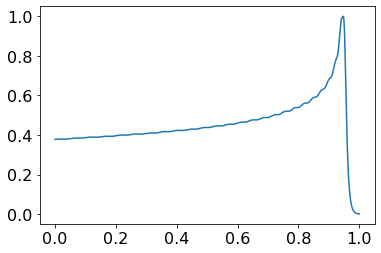

In [313]:
plt.plot(X_train, y_train)

In [314]:
X_train_fit, X_test_fit, y_train_fit, y_test_fit = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# ExU layer 

In [315]:
import pugna.layers

In [316]:
# s2Relu
s2Relu_activation = tf.keras.layers.Lambda(lambda x: tf.sin(2*np.pi*x)*(tf.nn.relu(-(x-1)) * tf.nn.relu(x)))

In [373]:
units_exu = 1000
# units_exu = 500

# units = 256
units = 32

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(1,)))
model.add(pugna.layers.ExU(units_exu))
model.add(tf.keras.layers.Dense(units, activation='tanh'))
model.add(tf.keras.layers.Dense(units, activation='tanh'))
# model.add(tf.keras.layers.Dense(units, activation='relu'))
# model.add(tf.keras.layers.Dense(units, activation='relu'))
model.add(tf.keras.layers.Dense(units, activation='relu'))
model.add(tf.keras.layers.Dense(units, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

In [374]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ex_u_5 (ExU)                 (None, 1000)              2000      
_________________________________________________________________
dense_355 (Dense)            (None, 32)                32032     
_________________________________________________________________
dense_356 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_357 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_358 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_359 (Dense)            (None, 1)                 33        
Total params: 37,233
Trainable params: 37,233
Non-trainable params: 0
__________________________________________________

In [375]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [376]:
yhat_prior = model.predict(X_train)

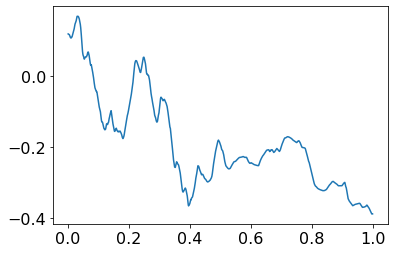

In [377]:
plt.figure()
plt.plot(X_train, yhat_prior)

In [378]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=400, factor=0.9, monitor='loss')]
history = model.fit(X_train, y_train, epochs=5000, verbose=0, batch_size=X_train.shape[0]//2, callbacks=callbacks)

CPU times: user 8min 49s, sys: 9min 15s, total: 18min 4s
Wall time: 3min 33s


In [379]:
history.history['loss'][-1]

2.755226887529716e-06

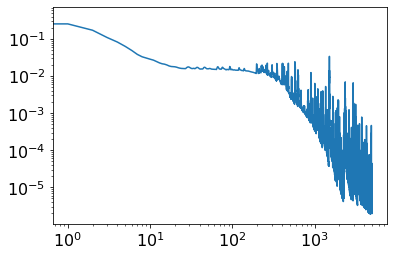

In [380]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')
plt.xscale('log')

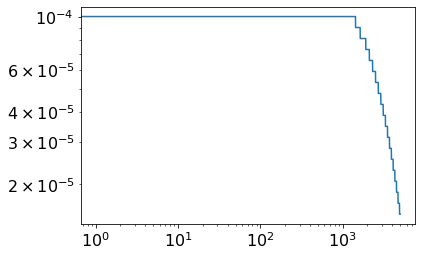

In [381]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')
plt.xscale('log')

In [382]:
yhat = model.predict(X_train)

In [383]:
yhat.shape

(4683, 1)

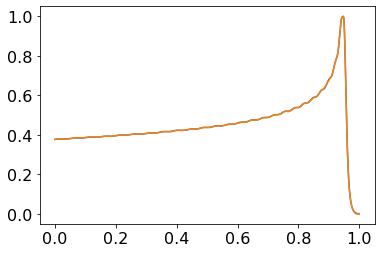

In [384]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)

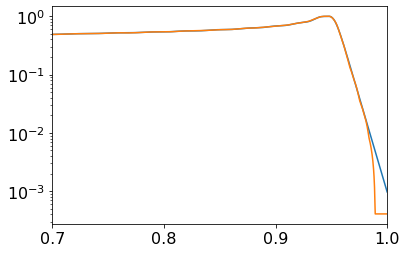

In [385]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)
plt.xlim(0.7, 1)
plt.yscale('log')

(0.7, 1.0)

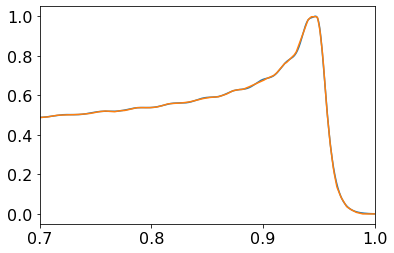

In [386]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)
plt.xlim(0.7, 1)
# plt.yscale('log')

# custom layer

In [22]:
# https://www.tensorflow.org/tutorials/customization/custom_layers
# https://github.com/keras-team/keras/blob/v2.8.0/keras/layers/core/dense.py#L31-L264
# https://github.com/google-research/google-research/blob/master/neural_additive_models/models.py

class MyDenseLayer(tf.keras.layers.Layer):
    def __init__(self, num_outputs, activation=None, name=None, trainable = True):
        """num_outputs == units"""
        super(MyDenseLayer, self).__init__(trainable=trainable, name=name)
        self.num_outputs = num_outputs
        self.activation = tf.keras.activations.get(activation)
        self._trainable = trainable

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=[int(input_shape[-1]),
                                             self.num_outputs],
                                      initializer=tf.initializers.GlorotUniform(),
                                      trainable=self._trainable
                                     )
        self.bias = self.add_weight("bias",
                                      shape=[self.num_outputs,],
                                    trainable=self._trainable,
                                    initializer=tf.initializers.Zeros(),
                                   )

        
        # this is wrong - should be a shift_bias for each unit - check ExU
        self.shift_bias = self.add_weight("shift_bias",
                                      shape=[int(input_shape[-1]),],
                                          trainable=False,
                                          initializer=tf.initializers.RandomUniform(minval=-1.0, maxval=1.0)
                                         )
        
        
        # this is wrong - should be a scale for each unit - check ExU
        self.scale = self.add_weight("scale",
                                      shape=[int(input_shape[-1]),],
                                     trainable=False,
                                     initializer=tf.initializers.RandomUniform(minval=1.0, maxval=100.0)
                                    )

    def call(self, inputs):
        shifted = inputs+self.shift_bias
        scaled = tf.math.multiply(shifted, self.scale)
        
        outputs = tf.matmul(scaled, self.kernel) + self.bias
        
#         outputs = tf.matmul(inputs, self.kernel) + self.bias
        
        if self.activation is not None:
            outputs = self.activation(outputs)
        
        return outputs

In [23]:
# units is the dimensionality of the output space
units = 5

In [24]:
# s2Relu
activation = tf.keras.layers.Lambda(lambda x: tf.sin(2*np.pi*x)*(tf.nn.relu(-(x-1)) * tf.nn.relu(x)))

In [25]:
layer = MyDenseLayer(units, activation=activation)

In [26]:
n_samples = 2
n_features = 2
input_tensor = tf.ones(shape=(n_samples, n_features))
input_tensor

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [27]:
layer(input_tensor)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[ 0., -0.,  0., -0.,  0.],
       [ 0., -0.,  0., -0.,  0.]], dtype=float32)>

In [28]:
(input_tensor + layer.shift_bias)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.8472986, 1.9980588],
       [1.8472986, 1.9980588]], dtype=float32)>

In [29]:
layer.kernel

<tf.Variable 'my_dense_layer/kernel:0' shape=(2, 5) dtype=float32, numpy=
array([[ 0.18816423, -0.1781196 , -0.3990035 ,  0.09003329,  0.16028929],
       [ 0.6125096 , -0.42235196,  0.52322066,  0.3284695 ,  0.5029249 ]],
      dtype=float32)>

In [30]:
layer.shift_bias

<tf.Variable 'my_dense_layer/shift_bias:0' shape=(2,) dtype=float32, numpy=array([0.8472986, 0.9980588], dtype=float32)>

In [31]:
layer.bias

<tf.Variable 'my_dense_layer/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>

In [32]:
# activation = 'relu'
activation = tf.keras.layers.Lambda(lambda x: tf.sin(2*np.pi*x)*(tf.nn.relu(-(x-1)) * tf.nn.relu(x)))

In [33]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(1,)))
model.add(MyDenseLayer(1000, activation=activation))
# model.add(MyDenseLayer(256, activation=activation))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_dense_layer_1 (MyDenseLay (None, 1000)              2002      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               128128    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 179,795
Trainable params: 179,793
Non-trainable params: 2
________________________________________________

In [35]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [36]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='loss')]
history = model.fit(X_train, y_train, epochs=1000, verbose=0, batch_size=X_train.shape[0]//2, callbacks=callbacks)

CPU times: user 4min 2s, sys: 1min 36s, total: 5min 39s
Wall time: 1min 1s


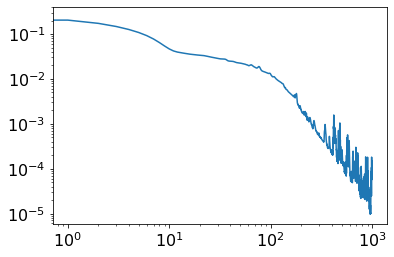

In [37]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')
plt.xscale('log')

In [38]:
yhat = model.predict(X_train)

In [39]:
yhat.shape

(4683, 1)

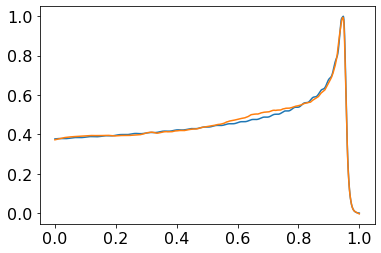

In [40]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)

# new implementation - create a new layer after the input layer that basically does shift/scale feature engineering 

In [1228]:
# https://www.tensorflow.org/tutorials/customization/custom_layers
# https://github.com/keras-team/keras/blob/v2.8.0/keras/layers/core/dense.py#L31-L264
# https://github.com/google-research/google-research/blob/master/neural_additive_models/models.py

class ShiftScaleLayer(tf.keras.layers.Layer):
    def __init__(self, num_outputs, activation=None, name=None, trainable=False):
        """num_outputs == units"""
        super(ShiftScaleLayer, self).__init__(trainable=trainable, name=name)
        self.num_outputs = num_outputs
        self._trainable = trainable
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.shift_bias = self.add_weight("shift_bias",
                                      shape=[self.num_outputs,],
                                          trainable=self._trainable,
                                          initializer=tf.initializers.Constant(tf.linspace(start=-1.0, stop=0., num=self.num_outputs))
#                                           initializer=tf.initializers.RandomUniform(minval=-1.0, maxval=0.)
                                         )
        
        
        self.scale = self.add_weight("scale",
                                      shape=[self.num_outputs,],
                                     trainable=False,
#                                      initializer=tf.keras.initializers.GlorotNormal()
#                                      initializer=tf.initializers.TruncatedNormal(mean=4.0, stddev=0.5)
                                     initializer=tf.initializers.RandomUniform(minval=1.0, maxval=100.0)
#                                      initializer=tf.initializers.RandomUniform(minval=-20.0, maxval=20.0)
#                                      initializer=tf.initializers.RandomNormal(mean=0., stddev=5.)
                                    )
        
        self.weight = self.add_weight("weight",
                                      shape=[self.num_outputs,],
                                     trainable=True,
                                     initializer=tf.keras.initializers.GlorotNormal()
#                                      initializer=tf.initializers.TruncatedNormal(mean=4.0, stddev=0.5)
#                                      initializer=tf.initializers.RandomUniform(minval=1.0, maxval=100.0)
#                                      initializer=tf.initializers.RandomUniform(minval=-20.0, maxval=20.0)
#                                      initializer=tf.initializers.RandomNormal(mean=0., stddev=5.)
                                    )

    def call(self, inputs):
#         print(inputs)
#         print(self.shift_bias)
        shifted = inputs+self.shift_bias
#         shifted = inputs
#         print(shifted)
#         print(self.scale)
#         scaled = tf.math.multiply(shifted, self.scale)
#         scaled = tf.math.multiply(shifted, tf.math.exp(self.scale))
        scaled = tf.math.multiply(shifted, tf.math.multiply(self.weight, self.scale))
        
        outputs = scaled
        
        if self.activation is not None:
            outputs = self.activation(outputs)
        
        # also concat inupt un-transformed times with transformed times
        # allows for global trend - otherwise everything is localised with
        # something like s2relu typically
#         outputs = tf.keras.layers.concatenate([inputs, outputs])
        
        return outputs

In [1229]:
# units is the dimensionality of the output space
units = 5

In [1230]:
layer = ShiftScaleLayer(units)

In [1231]:
n_samples = 2
n_features = 1
input_tensor = tf.ones(shape=(n_samples, n_features))
input_tensor

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [1232]:
layer(input_tensor)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[-0.       ,  1.169081 , -0.0138598, -3.7860856,  2.0452352],
       [-0.       ,  1.169081 , -0.0138598, -3.7860856,  2.0452352]],
      dtype=float32)>

In [1233]:
(input_tensor + layer.shift_bias)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.  , 0.25, 0.5 , 0.75, 1.  ],
       [0.  , 0.25, 0.5 , 0.75, 1.  ]], dtype=float32)>

In [1234]:
layer.shift_bias

<tf.Variable 'shift_scale_layer_72/shift_bias:0' shape=(5,) dtype=float32, numpy=array([-1.  , -0.75, -0.5 , -0.25,  0.  ], dtype=float32)>

In [1235]:
layer.scale

<tf.Variable 'shift_scale_layer_72/scale:0' shape=(5,) dtype=float32, numpy=
array([27.24483  , 34.1835   ,  5.4296927, 98.41936  ,  5.317128 ],
      dtype=float32)>

In [1369]:
# activation = 'relu'
activation = tf.keras.layers.Lambda(lambda x: tf.sin(2*np.pi*x)*(tf.nn.relu(-(x-1)) * tf.nn.relu(x)))
# activation = tf.keras.layers.Lambda(lambda x: (tf.nn.relu(-(x-1)) * tf.nn.relu(x)))

# activation = None
# activation = "tanh"
# activation = "relu"

# shift_scale_units = 1000
# shift_scale_units = 500
# shift_scale_units = 100
# shift_scale_units = 10
shift_scale_units = 50

# units = 256
units = 32
# units = 128
# units = 100+1

trainable=True

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(1,)))
# model.add(ShiftScaleLayer(1000, activation=activation, trainable=False))


model.add(ShiftScaleLayer(shift_scale_units, activation=activation, trainable=trainable))


# model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)))
# model.add(tf.keras.layers.Dense(50, activation='tanh'))
# model.add(tf.keras.layers.Dense(units, activation='tanh'))
# model.add(tf.keras.layers.Dense(units, activation='tanh'))
model.add(tf.keras.layers.Dense(units, activation='relu'))
model.add(tf.keras.layers.Dense(units, activation='relu'))
model.add(tf.keras.layers.Dense(units, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)))
model.add(tf.keras.layers.Dense(units, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)))
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))


# inputs = tf.keras.layers.Input(shape=(1,))
# x_ssl = ShiftScaleLayer(shift_scale_units, activation=activation, trainable=trainable)(inputs)
# x = tf.keras.layers.Dense(units, activation='tanh')(x_ssl)
# x = tf.keras.layers.Dense(units, activation='tanh')(x)
# x = tf.keras.layers.add([x_ssl, x])
# outputs = tf.keras.layers.Dense(1, activation='linear')(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [1370]:
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shift_scale_layer_77 (ShiftS (None, 50)                150       
_________________________________________________________________
dense_592 (Dense)            (None, 32)                1632      
_________________________________________________________________
dense_593 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_594 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_595 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_596 (Dense)            (None, 1)                 33        
Total params: 4,983
Trainable params: 4,933
Non-trainable params: 50
__________________________________________________

In [1371]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
# model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

In [1372]:
yhat_prior = model.predict(X_train)

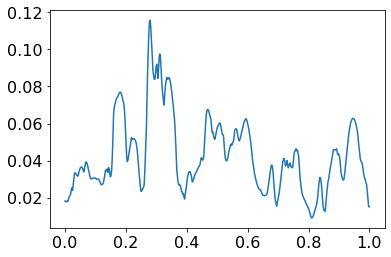

In [1373]:
plt.figure()
plt.plot(X_train, yhat_prior)

In [1374]:
og_shift_bias = model.layers[0].shift_bias.numpy()
og_scale = model.layers[0].scale.numpy()
og_weight = model.layers[0].weight.numpy()

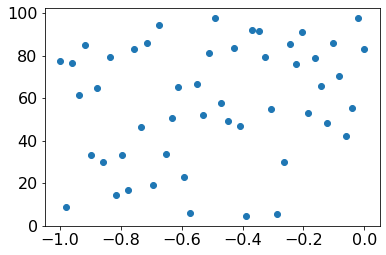

In [1375]:
plt.plot(model.layers[0].shift_bias.numpy(), model.layers[0].scale.numpy(), 'o')

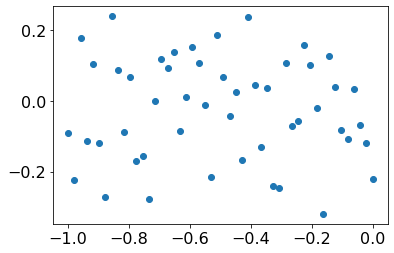

In [1376]:
plt.plot(model.layers[0].shift_bias.numpy(), model.layers[0].weight.numpy(), 'o')

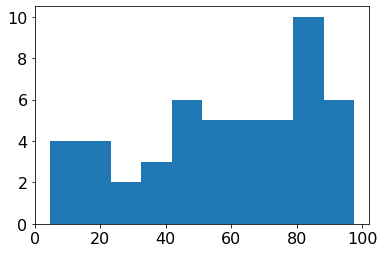

In [1377]:
plt.hist(model.layers[0].scale.numpy());

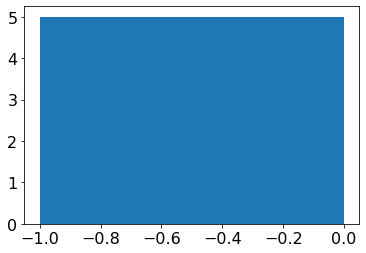

In [1378]:
plt.hist(model.layers[0].shift_bias.numpy());

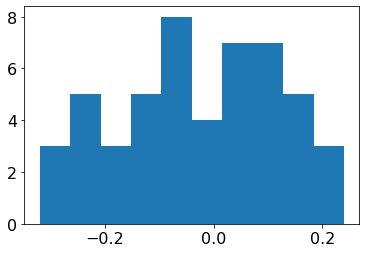

In [1379]:
plt.hist(model.layers[0].weight.numpy());

In [1380]:
%%time
# callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=400, factor=0.9, monitor='loss')]
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-5, patience=1000, factor=0.2, monitor='loss')]
# callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=1000, factor=0.5, monitor='loss')]
history = model.fit(X_train_fit, y_train_fit, epochs=5000, verbose=0, batch_size=X_train_fit.shape[0]//2, callbacks=callbacks, validation_data=(X_test_fit, y_test_fit))
# history = model.fit(X_train_fit, y_train_fit, epochs=5, verbose=0, batch_size=X_train_fit.shape[0]//2, callbacks=callbacks, validation_data=(X_test_fit, y_test_fit))

CPU times: user 3min 34s, sys: 31.9 s, total: 4min 6s
Wall time: 3min 6s


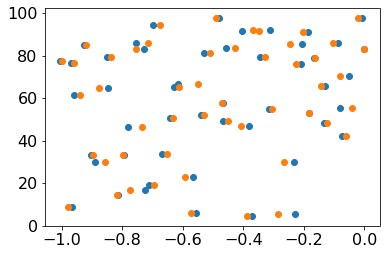

In [1381]:
plt.plot(model.layers[0].shift_bias.numpy(), model.layers[0].scale.numpy(), 'o')
plt.plot(og_shift_bias, og_scale, 'o')

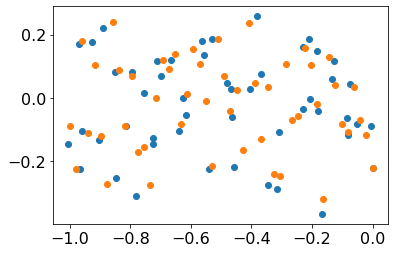

In [1382]:
plt.plot(model.layers[0].shift_bias.numpy(), model.layers[0].weight.numpy(), 'o')
plt.plot(og_shift_bias, og_weight, 'o')

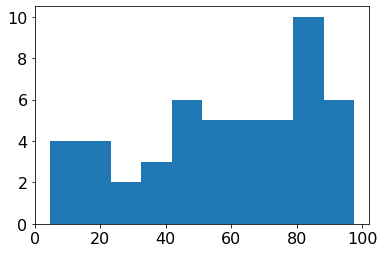

In [1383]:
plt.hist(model.layers[0].scale.numpy());

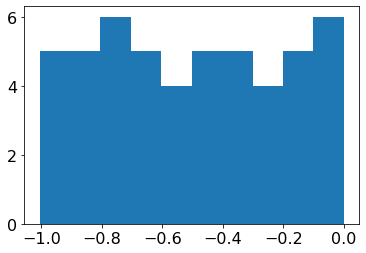

In [1384]:
plt.hist(model.layers[0].shift_bias.numpy());

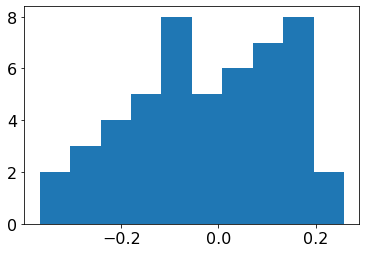

In [1385]:
plt.hist(model.layers[0].weight.numpy());

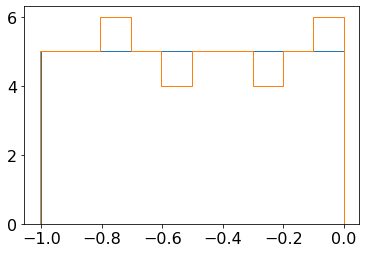

In [1386]:
plt.hist(og_shift_bias, histtype='step');
plt.hist(model.layers[0].shift_bias.numpy(), histtype='step');

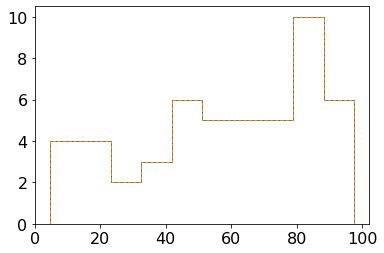

In [1387]:
plt.hist(og_scale, histtype='step');
plt.hist(model.layers[0].scale.numpy(), histtype='step', linestyle='--');

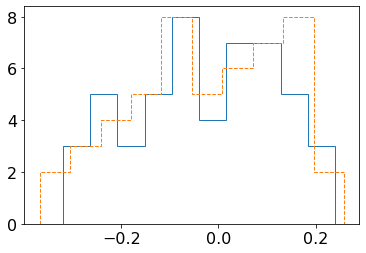

In [1388]:
plt.hist(og_weight, histtype='step');
plt.hist(model.layers[0].weight.numpy(), histtype='step', linestyle='--');

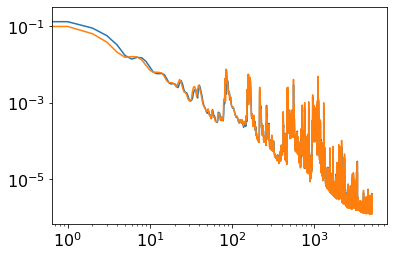

In [1389]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xscale('log')

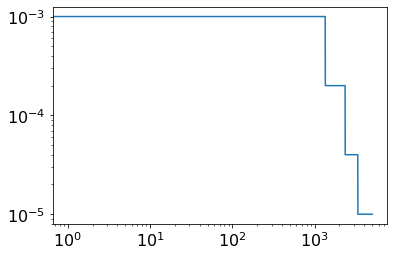

In [1390]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')
plt.xscale('log')

In [1391]:
yhat = model.predict(X_train)

In [1392]:
yhat.shape

(4683, 1)

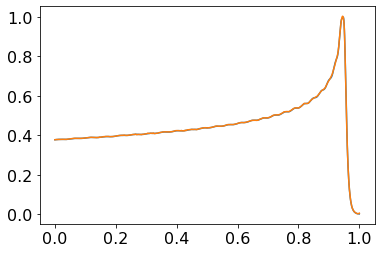

In [1393]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)

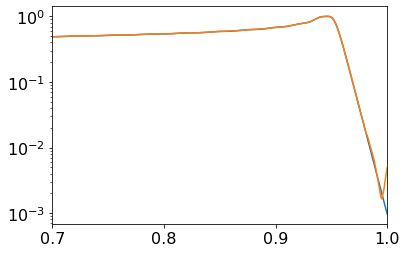

In [1394]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)
plt.xlim(0.7, 1)
plt.yscale('log')

(0.7, 1.0)

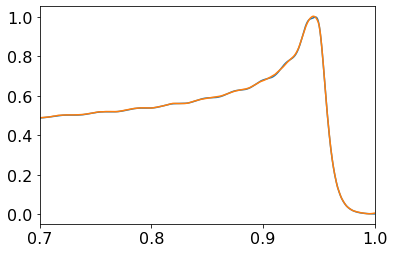

In [1395]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)
plt.xlim(0.7, 1)
# plt.yscale('log')

# old pugna Mscale layer

In [62]:
import pugna.models

In [63]:
# activation = tf.keras.layers.Lambda(lambda x: tf.sin(2*np.pi*x)*(tf.nn.relu(-(x-1)) * tf.nn.relu(x)))

In [64]:
model_mscale_2 = pugna.models.mscalednn.build_model_2(
    input_shape=1,
    output_shape=1,
    mscale_units=1000,
    mscale_activation='s2relu',
    nscales=5,
    scale_name='base2',
    units=[256,256],
    activation='relu',
    mscale_bias_initializer=[-0.05, 0.05]
)

In [65]:
model_mscale_2.layers[0].K

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.

In [66]:
model_mscale_2.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [67]:
model_mscale_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mscale_1 (Mscale)            (None, 1000)              2000      
_________________________________________________________________
activation (Activation)      (None, 1000)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               256256    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 324,305
Trainable params: 324,305
Non-trainable params: 0
_________________________________________________________________


In [68]:
yhat_prior = model_mscale_2.predict(X_train)

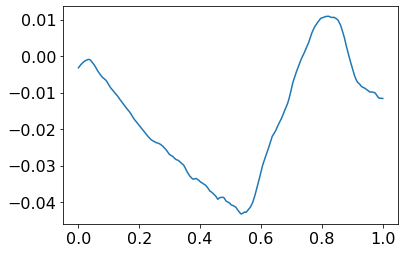

In [69]:
plt.figure()
plt.plot(X_train, yhat_prior)

In [70]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='loss')]
# callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=1000, factor=0.5, monitor='loss')]
history = model_mscale_2.fit(X_train_fit, y_train_fit, epochs=3000, verbose=0, batch_size=X_train_fit.shape[0]//2, callbacks=callbacks, validation_data=(X_test_fit, y_test_fit))

CPU times: user 13min 37s, sys: 3min 25s, total: 17min 3s
Wall time: 4min 29s


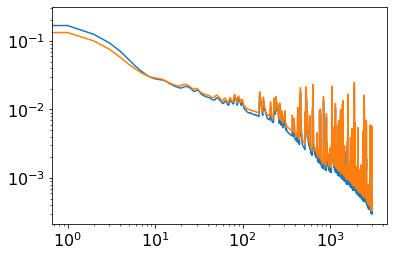

In [71]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xscale('log')

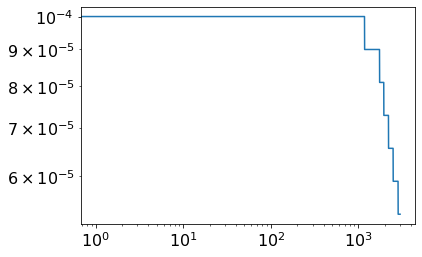

In [72]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')
plt.xscale('log')

In [73]:
yhat = model_mscale_2.predict(X_train)

In [74]:
yhat.shape

(4683, 1)

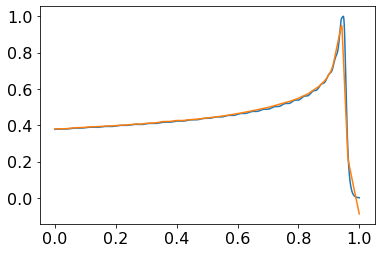

In [75]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)

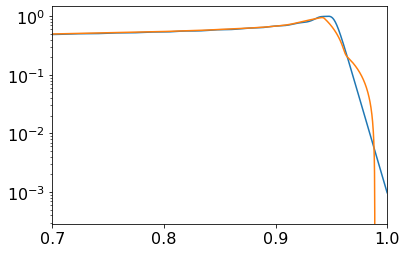

In [76]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)
plt.xlim(0.7, 1)
plt.yscale('log')

# wispy mscale

In [77]:
import wispy.mscalev5

In [78]:
activation = tf.keras.layers.Lambda(lambda x: tf.sin(2*np.pi*x)*(tf.nn.relu(-(x-1)) * tf.nn.relu(x)))
model_wispy_mscalev5 = wispy.mscalev5.build_model(
    input_shape=1,
    output_shape=1,
    units=[256,256,256],
    activation="relu",
    scale_activation=activation,
    n_blocks=[1, 1, 1],
    scales=[1, 10, 50],
    layers_per_block=3,
    scale_dimension=0,
    dtype=None,
    skip_connection=False,
    skip_connection_dense=False,
    final_dense=False,
)


In [79]:
model_wispy_mscalev5.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [80]:
model_wispy_mscalev5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer (ScaleLayer)        (None, 1)            0           input_5[0][0]                    
__________________________________________________________________________________________________
scale_layer_1 (ScaleLayer)      (None, 1)            0           input_5[0][0]                    
__________________________________________________________________________________________________
scale_layer_2 (ScaleLayer)      (None, 1)            0           input_5[0][0]                    
______________________________________________________________________________________________

In [81]:
yhat_prior = model_wispy_mscalev5.predict(X_train)

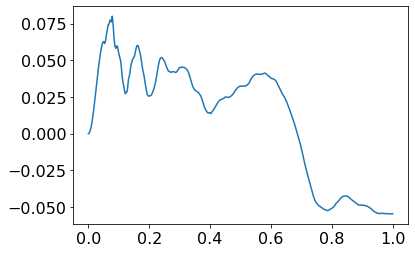

In [82]:
plt.figure()
plt.plot(X_train, yhat_prior)

In [83]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.4, monitor='loss'),
          tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)
          ]
# callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=1000, factor=0.5, monitor='loss')]
history = model_wispy_mscalev5.fit(X_train_fit, y_train_fit, epochs=3000, verbose=0, batch_size=X_train_fit.shape[0]//2, callbacks=callbacks, validation_data=(X_test_fit, y_test_fit))

CPU times: user 14min 52s, sys: 3min 2s, total: 17min 55s
Wall time: 3min 40s


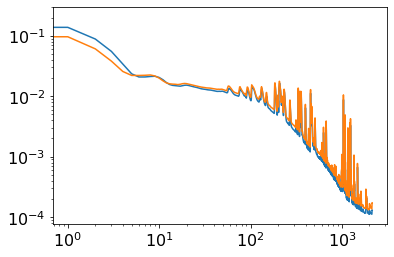

In [84]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xscale('log')

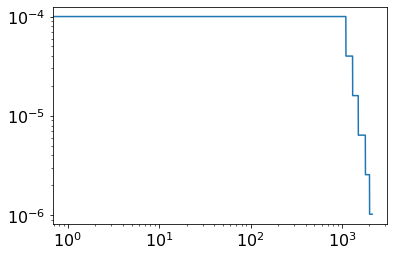

In [85]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')
plt.xscale('log')

In [86]:
yhat = model_wispy_mscalev5.predict(X_train)

In [87]:
yhat.shape

(4683, 1)

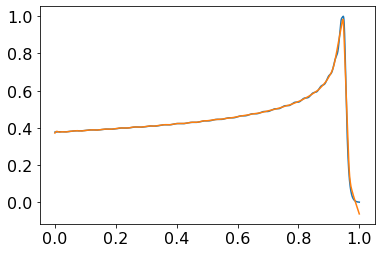

In [88]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)

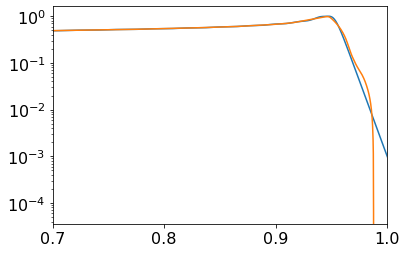

In [89]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)
plt.xlim(0.7, 1)
plt.yscale('log')

# wispy mscale v5 but with concat instead of add

In [90]:

import tensorflow as tf
from wispy.mscalev3 import make_scale_tensor, ScaleLayer


def build_subnetwork(
    input_tensor,
    output_shape,
    units,
    output_name,
    activation="relu",
    n_blocks=1,
    layers_per_block=3,
    skip_connection=False,
    skip_connection_dense=False,
):
    """
    subnetwork with the option of skip-connections

    n_blocks >= 1
    """
    assert n_blocks >= 1, f"n_blocks must be >=1, got {n_blocks}"

    if skip_connection:
        if skip_connection_dense:
            tmp = tf.keras.layers.Dense(units, activation=activation)(input_tensor)
        else:
            tmp = input_tensor

    # x = tf.keras.layers.Dense(units, activation=activation)(input_tensor)
    x = input_tensor

    # x = tfa.layers.GroupNormalization(groups=1)(x)
    # x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    for _ in range(n_blocks):
        for _ in range(layers_per_block):
            x = tf.keras.layers.Dense(units, activation=activation)(x)
        # x = tfa.layers.GroupNormalization(groups=1)(x)
        # x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)

        if skip_connection:
            x = tf.keras.layers.add([x, tmp])
            tmp = x

    # single output here?
    x = tf.keras.layers.Dense(output_shape, activation="linear", name=output_name)(x)

    return x


def new_concat_build_model(
    input_shape=1,
    output_shape=1,
    units=[128],
    activation="relu",
    scale_activation="relu",
    n_blocks=[1],
    scales=[1],
    layers_per_block=3,
    scale_dimension=0,
    dtype=None,
    skip_connection=False,
    skip_connection_dense=False,
    final_dense=False,
):
    """[summary]

    Args:
        input_shape (int, optional): [description]. Defaults to 1.
        output_shape (int, optional): [description]. Defaults to 1.
        units (list, optional): [description]. Defaults to [128].
        activation (str, optional): [description]. Defaults to "relu".
        n_blocks (list, optional): [description]. Defaults to [2].
        scales (list, optional): [description]. Defaults to [1].
        layers_per_block (int, optional): [description]. Defaults to 3.
        scale_dimension (int, optional): [description]. Defaults to 0.
            Use this to select which feature to apply the scaling to.
        dtype ([type], optional): [description]. Defaults to None.

    Returns:
        [type]: [description]
    """
    assert (
        len(scales) == len(n_blocks) == len(units)
    ), "units, n_blocks, scales must have same length"

    input_layer = tf.keras.Input(shape=(input_shape,))

    # create sub-networks
    xs = []
    for i, scale in enumerate(scales):
        scale_tensor = make_scale_tensor(
            input_shape, scale_dimension, scale, dtype=dtype
        )
        scaled_input = ScaleLayer(scale_tensor)(input_layer)
        scaled_input = tf.keras.layers.Dense(units[i], activation=scale_activation)(
            scaled_input
        )
        xs.append(
            build_subnetwork(
                input_tensor=scaled_input,
                output_shape=output_shape,
                units=units[i],
                activation=activation,
                n_blocks=n_blocks[i],
                layers_per_block=layers_per_block,
                skip_connection=skip_connection,
                skip_connection_dense=skip_connection_dense,
                output_name=f"outputs_{i}",
            )
        )

    if len(xs) > 1:
        output_layer = tf.keras.layers.concatenate([x for x in xs])
    else:
        output_layer = xs[0]

    if final_dense:
        output_layer = tf.keras.layers.Dense(output_shape, activation="linear")(
            output_layer
        )
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model


In [91]:
activation = tf.keras.layers.Lambda(lambda x: tf.sin(2*np.pi*x)*(tf.nn.relu(-(x-1)) * tf.nn.relu(x)))
model_new_concat = new_concat_build_model(
    input_shape=1,
    output_shape=1,
    units=[256,256,256],
    activation="relu",
    scale_activation=activation,
    n_blocks=[1, 1, 1],
    scales=[1, 10, 50],
    layers_per_block=3,
    scale_dimension=0,
    dtype=None,
    skip_connection=False,
    skip_connection_dense=False,
    final_dense=True,
)


In [92]:
model_new_concat.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [93]:
model_new_concat.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer_3 (ScaleLayer)      (None, 1)            0           input_6[0][0]                    
__________________________________________________________________________________________________
scale_layer_4 (ScaleLayer)      (None, 1)            0           input_6[0][0]                    
__________________________________________________________________________________________________
scale_layer_5 (ScaleLayer)      (None, 1)            0           input_6[0][0]                    
____________________________________________________________________________________________

In [94]:
yhat_prior = model_new_concat.predict(X_train)

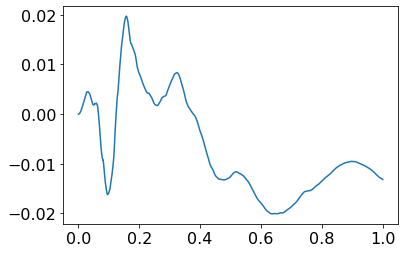

In [95]:
plt.figure()
plt.plot(X_train, yhat_prior)

In [96]:
%%time
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='loss'),
           tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)
          ]
# callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=1000, factor=0.5, monitor='loss')]
history = model_new_concat.fit(X_train_fit, y_train_fit, epochs=3000, verbose=0, batch_size=X_train_fit.shape[0]//2, callbacks=callbacks, validation_data=(X_test_fit, y_test_fit))

CPU times: user 20min 49s, sys: 4min 25s, total: 25min 14s
Wall time: 5min 10s


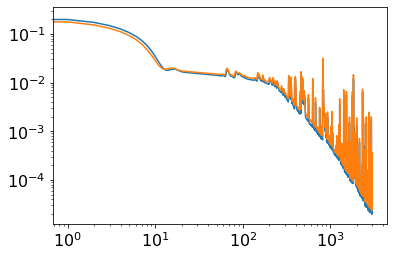

In [97]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xscale('log')

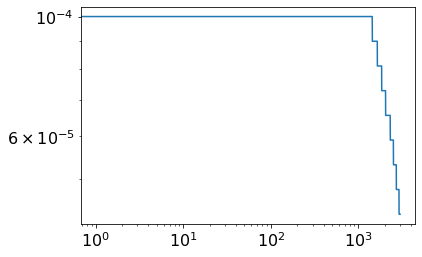

In [98]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')
plt.xscale('log')

In [99]:
yhat = model_new_concat.predict(X_train)

In [100]:
yhat.shape

(4683, 1)

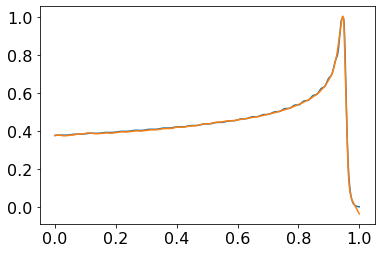

In [101]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)

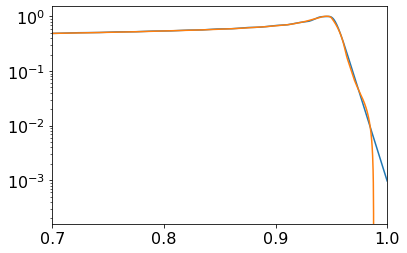

In [102]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)
plt.xlim(0.7, 1)
plt.yscale('log')

# hierarchical: first each input we make a shift sub-network then from each of those we build a m-scale sub-network

In [22]:
 def make_shift_tensor(input_shape, shift, dtype=None):
    shifts = np.ones(shape=(input_shape,), dtype=dtype)
    shifts *= shift
    return shifts



class ShiftLayer(tf.keras.layers.Layer):
    def __init__(self, shift_tensor, **kwargs):
        super(ShiftLayer, self).__init__()
        self.shift_tensor = shift_tensor

    def call(self, inputs):
        return tf.math.add(inputs, self.shift_tensor)

    def get_config(self):
        config = super(ShiftLayer, self).get_config()
        config.update({"shift_tensor": self.shift_tensor})
        return config


In [23]:
from wispy.mscalev3 import make_scale_tensor, ScaleLayer 

In [52]:
def shift_scale_build_subnetwork(input_tensor, output_shape, units, activation, layers_per_block, output_name):
    x = input_tensor
    for _ in range(layers_per_block):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        
    x = tf.keras.layers.Dense(output_shape, activation="linear", name=output_name)(x)
    return x

In [53]:
from typing import List

In [54]:
def shift_scale_build_subnetwork_activation_list(input_tensor, output_shape, units, activations: List, layers_per_block, output_name):
    x = input_tensor
    for i in range(layers_per_block):
        x = tf.keras.layers.Dense(units, activation=activations[i])(x)
        
    x = tf.keras.layers.Dense(output_shape, activation="linear", name=output_name)(x)
    return x

In [57]:
def shift_scale_build_model(input_shape=1, output_shape=1, shifts=[-1,0,1], scales=[1,10,50,100], units=128, scale_activation='s2relu', activation='relu', layers_per_block=3, final_dense=False, add_layers=True, concat_layers=False):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    # create sub-networks
    
    counter=0
    xs = []
    for i, shift in enumerate(shifts):
        shift_tensor = make_shift_tensor(
            input_shape, shift, dtype=None
        )
        shifted_input = ShiftLayer(shift_tensor)(input_layer)
        # adding a dense layer seems to produce noisey outputs... not 100% sure though. only done a few tests.
#         shifted_input = tf.keras.layers.Dense(units, activation="linear")(
#             shifted_input
#         )
        for j, scale in enumerate(scales):
            scale_tensor = make_scale_tensor(
                input_shape, 0, scale, dtype=None
            )
            scaled_input = ScaleLayer(scale_tensor)(shifted_input)
            scaled_input = tf.keras.layers.Dense(units, activation=scale_activation)(
                scaled_input
            )
            counter+=1
#             print(counter)
#             xs.append(shift_scale_build_subnetwork(input_tensor=scaled_input, output_shape=output_shape, units=units, activation=activation, layers_per_block=layers_per_block, output_name=f"outputs_{counter}"))
            xs.append(shift_scale_build_subnetwork_activation_list(input_tensor=scaled_input, output_shape=output_shape, units=units, activations=activation, layers_per_block=layers_per_block, output_name=f"outputs_{counter}"))

    if len(xs) > 1:
        if add_layers:
            output_layer = tf.keras.layers.add([x for x in xs])
        elif concat_layers:
            output_layer = tf.keras.layers.concatenate([x for x in xs])
    else:
        output_layer = xs[0]

    if final_dense:
        output_layer = tf.keras.layers.Dense(output_shape, activation="linear")(output_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [288]:
s2relu_activation = tf.keras.layers.Lambda(lambda x: tf.sin(2*np.pi*x)*(tf.nn.relu(-(x-1)) * tf.nn.relu(x)))

units = 128
# units = 32

# activation='relu'

# layers_per_block=4 
# activation=['tanh','tanh','relu','relu']

layers_per_block=2
# activation=['tanh','relu']
activation=['relu','relu']

#     units=[256,256,256],
#     layers_per_block=3,

model_shift_scale = shift_scale_build_model(
    input_shape=1,
    output_shape=1,
    shifts=[0,-0.95],
    scales=[1,10,50],
    units=units,
    scale_activation='s2relu',
    activation=activation,
    layers_per_block=layers_per_block,
    final_dense=False,
    add_layers=True,
    concat_layers=False
)

In [289]:
model_shift_scale.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [290]:
model_shift_scale.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
shift_layer_29 (ShiftLayer)     (None, 1)            0           input_19[0][0]                   
__________________________________________________________________________________________________
shift_layer_30 (ShiftLayer)     (None, 1)            0           input_19[0][0]                   
__________________________________________________________________________________________________
scale_layer_85 (ScaleLayer)     (None, 1)            0           shift_layer_29[0][0]             
___________________________________________________________________________________________

In [291]:
yhat_prior = model_shift_scale.predict(X_train)

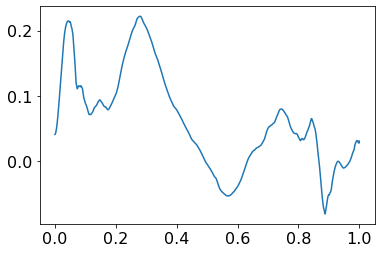

In [292]:
plt.figure()
plt.plot(X_train, yhat_prior)

In [293]:
# network prior output is in the range ~[-0.1, 0.1]
# dividing by 10 puts the data into this range
# and greatly increases convergence time
# y_test_fit /= 10
# y_train_fit /= 10
# y_train /= 10

In [294]:
X_train_fit.shape[0]//2

1568

In [295]:
%%time
# callbacks=None
callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-5, patience=300, factor=0.9, monitor='loss'),
#     tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-8, patience=20, factor=0.9, monitor='loss'),
#     tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)
]
# callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=1000, factor=0.5, monitor='loss')]

batch_size=X_train_fit.shape[0]//2
# batch_size=X_train_fit.shape[0] (use this with learning rate of 1e-3)
history = model_shift_scale.fit(X_train_fit, y_train_fit, epochs=5000, verbose=0, batch_size=batch_size, callbacks=callbacks, validation_data=(X_test_fit, y_test_fit))

CPU times: user 18min 34s, sys: 6min 35s, total: 25min 9s
Wall time: 5min 56s


In [296]:
model_shift_scale.layers[-1]

In [297]:
model_shift_scale.layers[-1].weights

[]

In [298]:
history.history['loss'][-1]

1.7371922922393424e-06

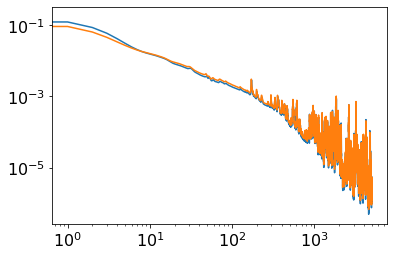

In [299]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xscale('log')

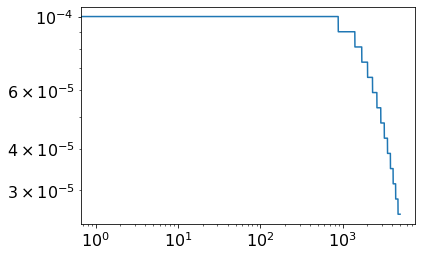

In [300]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')
plt.xscale('log')

In [301]:
yhat = model_shift_scale.predict(X_train)

In [302]:
yhat.shape

(4683, 1)

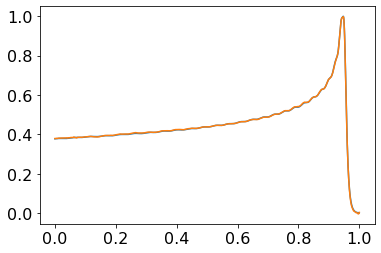

In [303]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)

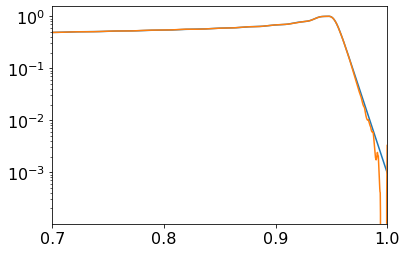

In [304]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)
plt.xlim(0.7, 1)
plt.yscale('log')

(0.8, 1.0)

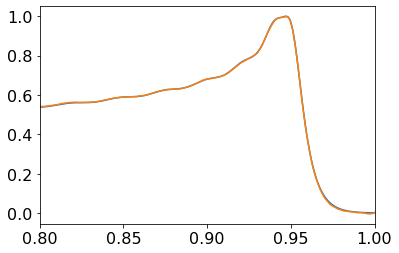

In [305]:
plt.figure()
plt.plot(X_train, y_train)
plt.plot(X_train, yhat)
plt.xlim(0.8,1)